In [83]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from inpainting.models.deepfillv1.DeepFill import DeepFillV1Model
from inpainting.models.pwcnet.model import PWCNetModel
from inpainting.models.utils import warp_tensor, fill_flow
from inpainting.visualize import flow_to_pil_image
%matplotlib inline

import glob
import matplotlib.pyplot as plt

import inpainting.transforms as T
from inpainting.load import VideoDataset, MergeDataset

In [84]:
images_dataset = VideoDataset(
    list(glob.glob(f'../data/interim/demo/ResizedJPEGImages/flamingo')),
    'image',
    sequence_length=2
)
masks_dataset = VideoDataset(
    list(glob.glob(f'../data/interim/demo/ResizedMasks/flamingo')),
    'mask',
    sequence_length=2
)
dataset = MergeDataset([images_dataset, masks_dataset], transform=T.ToTensor())
images, masks = next(iter(DataLoader(dataset)))

prev_image = images[0].cuda()
curr_image = images[1].cuda()
prev_mask = masks[0].cuda()
curr_mask = masks[1].cuda()

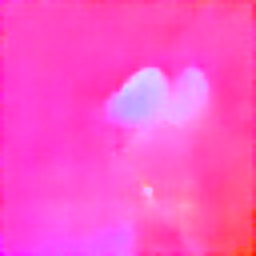

In [85]:
with torch.no_grad():
    flow_estimator = PWCNetModel('../models/external/pwcnet/network-default.pytorch').cuda()
    flow = flow_estimator(curr_image, prev_image)
flow_to_pil_image(flow[0].cpu())

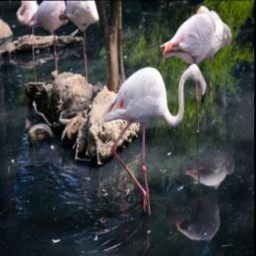

In [86]:
warped_image = warp_tensor(prev_image, flow)
to_pil_image(warped_image[0].cpu())

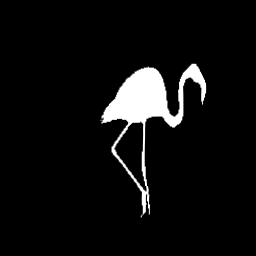

In [87]:
warped_mask = warp_tensor(prev_mask, flow)
to_pil_image(warped_mask[0].cpu())#%%

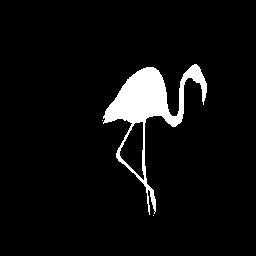

In [88]:
to_pil_image(curr_mask[0].cpu())

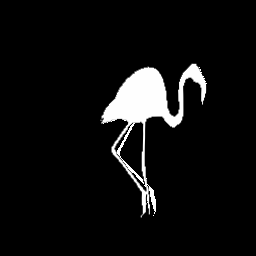

In [89]:
result_mask = curr_mask + warped_mask
to_pil_image(result_mask[0].cpu())

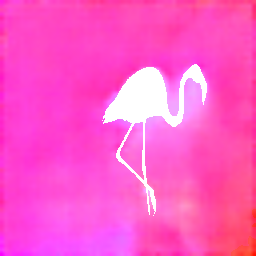

In [90]:
masked_flow = flow * (1 - curr_mask)
flow_to_pil_image(masked_flow[0].cpu())


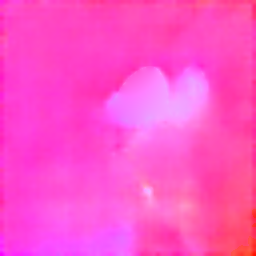

In [91]:
filled_flow = fill_flow(masked_flow, 1 - curr_mask)
flow_to_pil_image(filled_flow[0].cpu())

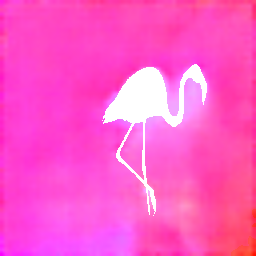

In [92]:
import flowiz as fz
from torchvision.transforms.functional import to_tensor

masked_flow_image = to_tensor(fz.convert_from_flow(
    masked_flow[0].cpu().numpy().transpose(1, 2, 0))).unsqueeze(0).cuda()
to_pil_image(masked_flow_image[0].cpu())

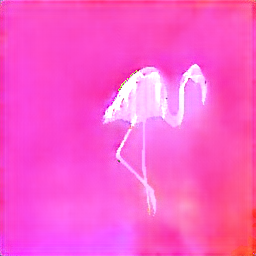

In [93]:
with torch.no_grad():
    net = DeepFillV1Model('../models/external/deepfillv1/imagenet_deepfill.pth').cuda()
    filled_flow_image = net(masked_flow_image, 1 - curr_mask)
to_pil_image(filled_flow_image[0].cpu())
